In [74]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import ast
import numpy as np
plt.style.use('tableau-colorblind10')
from matplotlib.lines import Line2D 

colors = ['#F0E442', '#D55E00', '#009E73', '#4D4D4D', '#56B4E9']  # Blue, Orange, Green, Yellow, Light Blue
colors_blind=[ '#FF800E', '#ABABAB', '#595959',
                 '#5F9ED1',  '#FFBC79',  '#C85200','#898989', '#A2C8EC','#006BA4','#CFCFCF',]
from CODES import base_other_codes as bc
from scipy import stats


In [75]:
class plotting_base:
    def __init__(self):
        self.x_fontsize_label=25
        self.y_fontsize_label=25
        self.x_fontsize=20
        self.y_fontsize=20
        self.t_fontsize=20
        self.size_prop=18

        self.row=5
        self.col=3


        self.figure_size=(18,25)
        # figure_size=(10,12)
        self.rotation=30
        self.w_space=0.00001
        self.h_space=None
        self.markersize=5
        self.title_font=18
        self.label_text='% corruption degree'
        self.x_label='Network layers'
        self.pad_value=10
        self.corruptions=[0.0,0.2,0.4,0.6,0.8]
        self.exp1='cor_label'
        self.mapping = {0.0:0,0.2:20, 0.4:40,0.6:60,0.8:80,1.0:100}
        self.mapping2 = {'MNIST':'MNIST','FashionMNIST':'Fashion-MNIST','CIFAR10':'CIFAR-10',
                'CIFAR100':'CIFAR-100','TinyImageNet':'Tiny ImageNet'}
        self.folders = {99:0.99,75:0.75,50:0.50,25:0.25,1:1 }
    def get_corrupt(self,val):
        return self.mapping.get(val, val)

    def get_dataname(self,val):
        return self.mapping2.get(val, val)
    def get_folder_name(self,val):
        return self.folders.get(val, val)
    
    def path_results(self,dataset,type_network,corrupt,seed_value,variance):
        basefolder=f'../sensitivity_ablation_studies/results/{seed_value}/angle_results_{variance}/{dataset}_{type_network}/results_{corrupt}'            
        file_path=f'{basefolder}/angle_results'
        return file_path
    def path_acc(self,dataset,type_network,corrupt):
        accu_path=f'../model_accuracy/{dataset}_{type_network}/{corrupt}'
        return accu_path
    def fun_1(self,train_overall,classnumber=99):
        if classnumber==99:
            max_value = list(map(max, zip(train_overall[0], train_overall[1],train_overall[2])))
            min_value = list(map(min, zip(train_overall[0], train_overall[1],train_overall[2])))
            avg_value = list(map(sum, zip(train_overall[0], train_overall[1],train_overall[2])))
            avg_value = [x/3 for x in avg_value]
        else:
            max_value = list(map(max, zip(train_overall[0][classnumber], train_overall[1][classnumber],train_overall[2][classnumber])))
            min_value = list(map(min, zip(train_overall[0][classnumber], train_overall[1][classnumber],train_overall[2][classnumber])))
            avg_value = list(map(sum, zip(train_overall[0][classnumber], train_overall[1][classnumber],train_overall[2][classnumber])))
            avg_value = [x/3 for x in avg_value]
        return max_value,min_value,avg_value
    def layernames(self,network_type,ds):

        if network_type=='MLP':
            x=[0,1,2,3]
            layers=['FC (128)','FC (512)','FC (2048)','FC (2048)']#'Input',
        if network_type=='CNN':
            if  ds == 'CIFAR10':
                layers=['Flat (1024)','FC (250)','FC (250)','FC (250)']#'Input',
            if  ds != 'CIFAR10':
                layers=['Flat (576)','FC (250)','FC (250)','FC (250)']#'Input',
            x=[0,1,2,3]
        if network_type=='AlexNet':
            x=[0,1,2]
            layers=['Flat (256)','FC (4096)','FC (4096)']
        return x,layers
    
    def epoch_number(self,network_path,corrupt,run):
        models=sorted(os.listdir(f'{network_path}/{corrupt}/Run_{run}'))
        model_numbers = [
            (m, int(m.split("_")[1].split(".")[0]))  
            for m in models if m.startswith("model_") and m.split("_")[1].split(".")[0].isdigit()
        ]
        model_highest = max(model_numbers, key=lambda x: x[1])
        return model_highest[1]
    
    def get_path(self,type_network,ds,corrupt,run):
        network_path=bc.path_network_fn(type_network,ds)
        epoch_number_value=self.epoch_number(network_path,corrupt,run)
        return epoch_number_value
        

In [81]:
class plot_accuracy_variance(plotting_base):    
    def model_accuracy_variance(self,ds,type_network,corrupt):
        accuracy_path=self.path_acc(ds,type_network,corrupt)
        run=1

        if type_network=='MLP':
            file_name=f'{accuracy_path}/Run{run}_Accuracy.csv'
            row_num=-2
            test_model=pd.read_csv(f'{file_name}')['Test_accuracy'].tolist()[row_num]
        else:
            file_name=f'{accuracy_path}/Run_{run}.csv'
            row_num=-1
            test_model=pd.read_csv(f'{file_name}')['Test_accuracy'].tolist()[row_num]/100

        if type_network in ['MLP','CNN']:
            number_layer=4
        else:
            number_layer=3
        test_model=np.tile(np.array(test_model)[np.newaxis], number_layer)

        return test_model

    def acc_probe_variance(self,type_network,ds,corrupt,file_path):
        filename='acc_overall_test'
        pca_layer,_,_=bc.layer_name(type_network,ds)
        run=1
        epoch_present=self.get_path(type_network,ds,corrupt,run)
        results_path=f'{file_path}/Run_{run}/{epoch_present}'
        test_acc_layer=[]
        for p_layer in pca_layer:
            file_load=f'{results_path}/layer_{p_layer}_{filename}.csv'
            test_acc_layer.append(pd.read_csv(file_load)['acc_overall'][0])
        test_acc_run=test_acc_layer
        return test_acc_run
    
    def variance_confidence(self, acc):

        data = np.array(acc)   # shape = (5 seeds, 4 layers)
        
        means = data.mean(axis=0)
        sems = stats.sem(data, axis=0)

        df = data.shape[0] - 1

        cis = []
        for i in range(len(means)):
            if sems[i] == 0:         # zero variance case
                cis.append((means[i], means[i]))
            else:
                cis.append(stats.t.interval(0.95, df, loc=means[i], scale=sems[i]))

        # Convert to lower/upper arrays
        lower = np.array([c[0] for c in cis])
        upper = np.array([c[1] for c in cis])

        ci_half = upper - means

#         for i in range(len(means)):
#             print(f"Metric {i}: {means[i]:.4f} ± {ci_half[i]:.4f} (95% CI)")
    
        return means,ci_half
    def plot_accuracy_variance(self,resfoldername,other):

        y_label='Test Accuracy'
        if other:
            self.col=4
            dataset=['CIFAR10','MNIST','CIFAR10','TinyImageNet']#
            type_networks=['MLP','CNN','CNN','AlexNet']#
            file_name=f'ACCURACY_other.pdf'
        else:
            dataset=['MNIST','FashionMNIST','CIFAR100']#
            type_networks=['MLP','CNN','AlexNet']#
            file_name=f'ACCURACY.pdf'
            self.col=3
        num_cols=6
        variances=[99,75,50,25,1]
        seed_values=[10,20,30,40,50]
        labels={'label0':'Model',
                'label1':f'MASC ({variances[0]}%)',
                'label2':f'MASC ({variances[1]}%)',
               'label3':f'MASC ({variances[2]}%)',
               'label4':f'MASC ({variances[3]}%)',
               'label5':f'MASC ({variances[4]} PC)'}
        

        fig = plt.figure(figsize=self.figure_size)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=self.w_space, hspace=self.h_space)
        count=1

        for corrupt in self.corruptions:    
            for ds,type_network in zip(dataset,type_networks):
#                 print(ds,type_networks)
                fig.add_subplot(self.row, self.col,count)
                test_model=self.model_accuracy_variance(ds,type_network,corrupt)
                x,layers=self.layernames(type_network,ds)
                    
                plt.plot(x,test_model,'--',markersize=self.markersize,label=labels[f'label0'],color=colors_blind[0])
                for i,var in enumerate(variances):
#                     print(i,probe)
                    variance=self.get_folder_name(var)
                    test_acc_run=[]
                    for seed_value in seed_values:
                        file_path=self.path_results(ds,type_network,
                                                    corrupt,seed_value,variance)
                        test_acc_run.append(self.acc_probe_variance(type_network,ds,corrupt,file_path))
                    test_mean,test_ci=self.variance_confidence(test_acc_run)
                    
                    x,layers=self.layernames(type_network,ds)
                    
                    plt.errorbar(
                        x, 
                        test_mean, 
                        yerr=test_ci,            # 95% CI half-width
                        fmt='-o',                # line + circle markers
                        capsize=5,               # size of the CI cap
                        markersize=self.markersize,
                        label=labels[f'label{i+1}'],
                        color=colors_blind[i+1]
                    )
                    
                if type_network!='AlexNet':
                    plt.ylim(-0.01,1.01)
                plt.xticks(x,layers,rotation=self.rotation,fontsize=self.x_fontsize)
                plt.yticks(fontsize=self.y_fontsize)
                
                if (count - 1) % self.col == 0:
                    plt.ylabel(f'{self.get_corrupt(corrupt)}{self.label_text}',fontsize=self.title_font)
#                 else:
#                     plt.tick_params(labelleft=False)
                    
                if count<= self.col:
                    plt.title(f'{type_network}-{self.get_dataname(ds)}',
                              fontsize=self.t_fontsize,pad=self.pad_value)
                if count<= (self.col*self.row)-self.col:
                    plt.tick_params(labelbottom=False)

                count=count+1

        fig.legend(labels=labels.values(), loc='upper center', bbox_to_anchor=(0.5, 1.01),
                   ncol=3,prop = { "size": self.size_prop})
        plt.tight_layout(rect=[0.05, 0.04, 1, 0.97])  
        
        fig.text(0.0, 0.5, y_label, va='center', rotation='vertical', fontsize=self.y_fontsize_label)

        fig.text(0.5, 0.001, self.x_label, ha='center',fontsize=self.x_fontsize_label)

        plt.savefig(f'{resfoldername}/{file_name}',format="pdf", bbox_inches="tight")
        

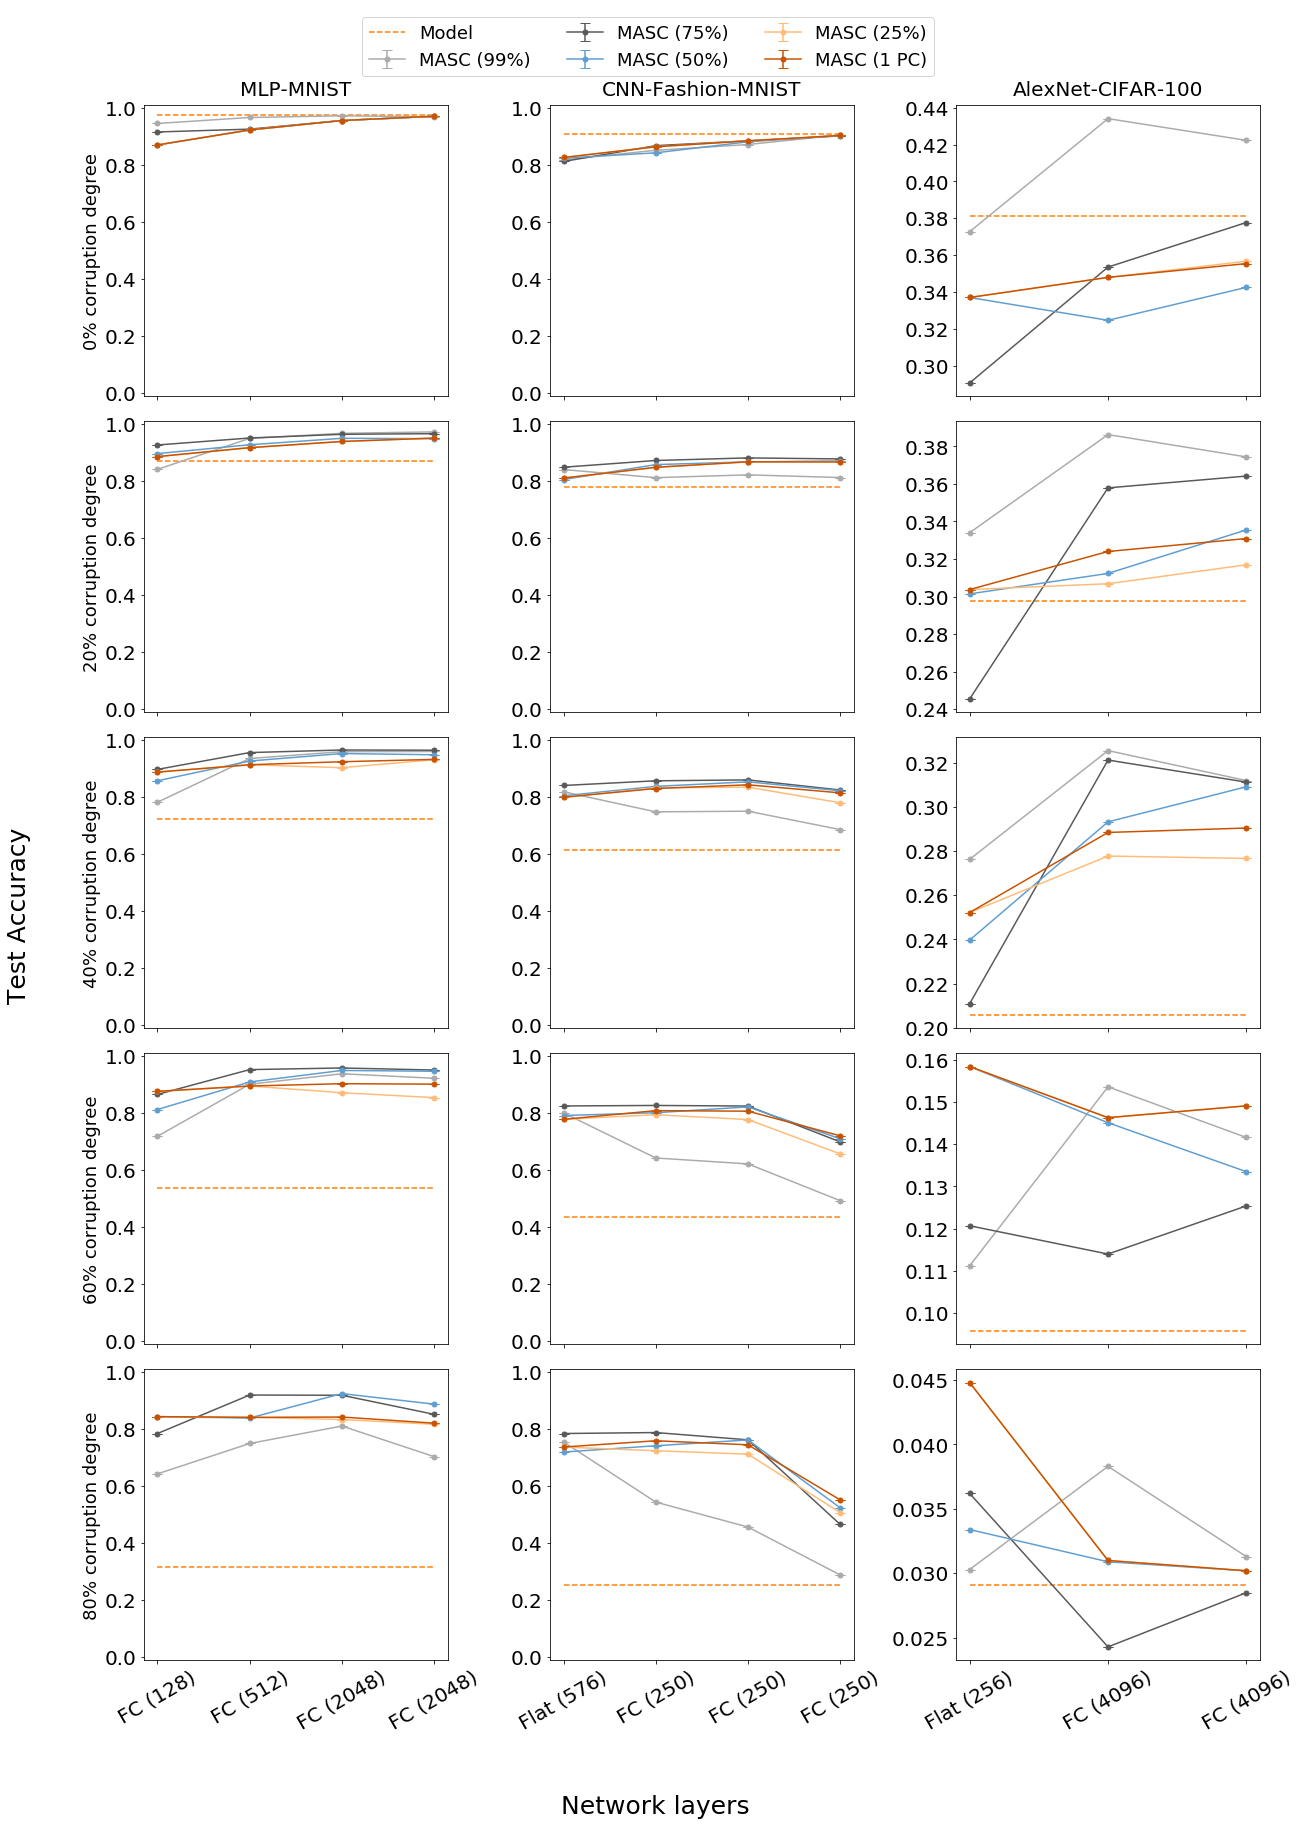

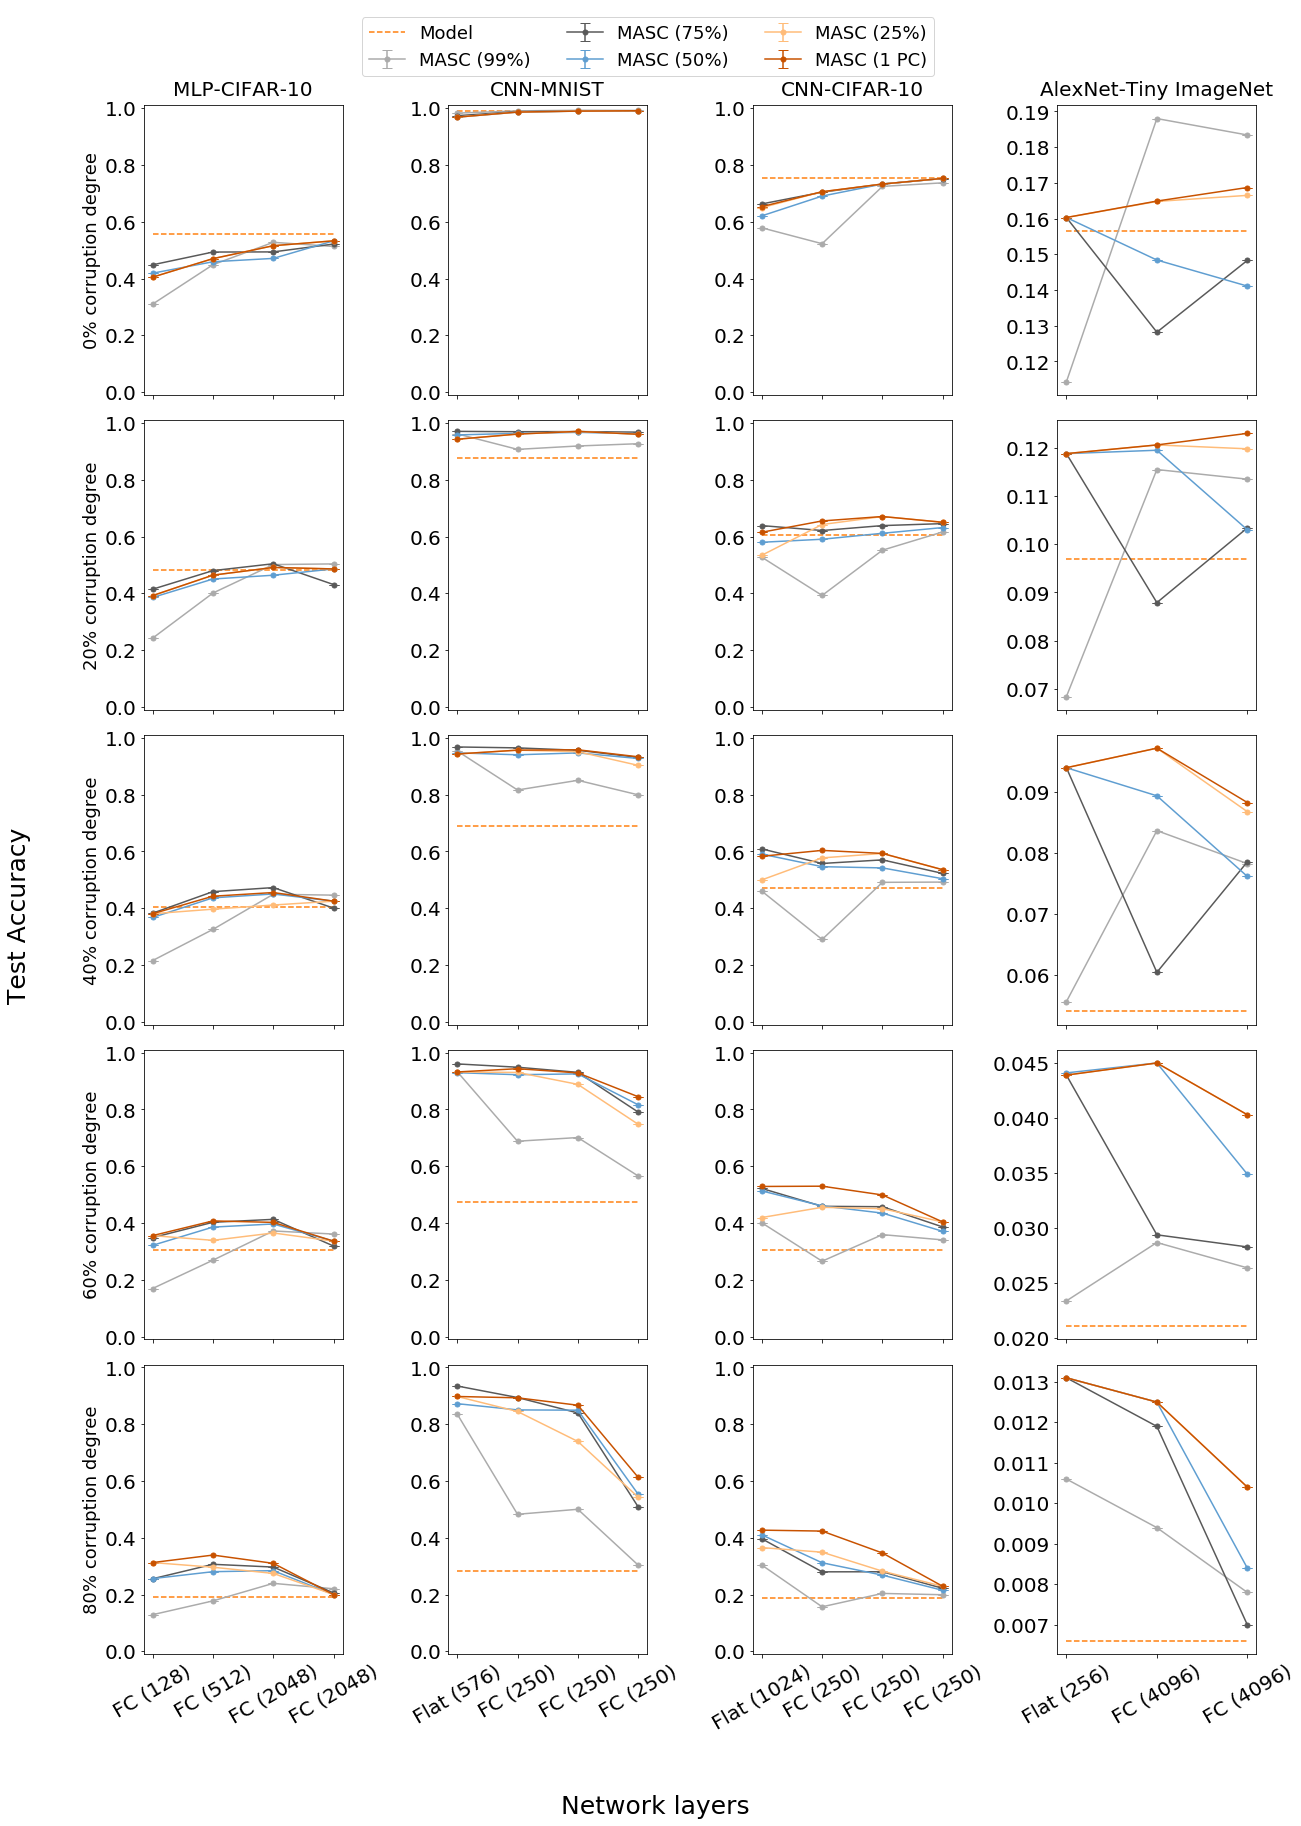

In [82]:
p1=plot_accuracy_variance()

resfoldername='plots/sensitivity_ablation_studies'
os.makedirs(f'{resfoldername}',exist_ok=True)

p1.plot_accuracy_variance(resfoldername,other=False)
p1.plot_accuracy_variance(resfoldername,other=True)